<h1>Life expectancy and GDP in 1800-2100</h1>

<p fontsize=13>In this project we look at GDP and Life Expectancy in various countries and see if the two are related in any way.</p>

<p>The datasets were taken from <a href='https://www.kaggle.com/datasets/ilyasahmedhassan/life-expectancy-and-gdp-growth-per-capita?select=gdp_pcap.csv'>Kaggle</a>.</p>

<p>First let us import the libraries<p>

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf



<p>Now let us open the csv files and look at the data that have.</p>

In [44]:
gdp_raw=pd.read_csv("gdp_pcap.csv")
life_exp_raw=pd.read_csv("Life Expectency.csv")

<p>First let's look at the GDP table. The columns are years from 1800 to 2100, the rows are the world countries, and the data is GDP (or expected GDP) per capita in US dollars. The dataframe does not have missing values and is almost ready to work with. However, there remain a couple of issues we need to address.</p>


In [45]:
display(gdp_raw.head())

,country,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,Afghanistan,583,583,583,583,583,583,583,583,583,...,3570,3700,3720,3830,3930,4030,4130,3900,4070,4030
1,Angola,452,454,456,458,460,462,464,466,468,...,20.6k,21.1k,21.7k,21.9k,22.3k,22.5k,23k,23.5k,24k,24.6k
2,Albania,569,571,572,574,576,577,579,581,582,...,37.6k,38.5k,39.4k,39.9k,40.9k,41.9k,41.4k,42.4k,43.7k,45.7k
3,Andorra,1660,1660,1670,1670,1670,1680,1680,1680,1690,...,59.2k,60k,60.3k,61k,61.7k,62.7k,61.9k,62.5k,62.9k,62.1k
4,United Arab Emirates,1390,1390,1390,1400,1410,1410,1420,1420,1430,...,86.2k,85.4k,84.1k,84.3k,84.6k,83.9k,84.2k,84k,84.1k,84.3k


<p>Firstly, the number of columns appears to be too big. Since the main goal here is to see whether there is any relation between GDP and life expectancy, we do not need 300 columns of GDP data. Therefore, for my analysis I only keep 1800,1850,1900,1950,2000 and 2050 columns.</p>

In [46]:
gdp_raw=gdp_raw[['country','1800','1850','1900','1950','2000','2050','2100']]

<p>Firstly, note that while some entries are numbers, there are entries that are strings of the form 'number k', before doing any analysis, we need to change that. We define a function that transforms strings of the form 'number k' into numbers.</p>

In [47]:
def convert_k_to_number(value):
    try:
        if isinstance(value, str) and value.lower().endswith('k'):
            # Remove the 'k' and convert to float, then multiply by 1000
            return float(value[:-1]) * 1000
        else:
            # Attempt to convert directly to float
            return float(value)
    except ValueError:
        # Return the value as-is in case of any conversion error
        return value

<p>Then we apply it to our dataframe and obtain the table 'gdp' that we are going to work with. Afterwards it will be ready for analysis.</p>

In [48]:
gdp=gdp_raw.applymap(convert_k_to_number)
display(gdp.head())

,country,1800,1850,1900,1950,2000,2050,2100
0,Afghanistan,583.0,622.0,846.0,1620.0,791.0,2390.0,4030.0
1,Angola,452.0,563.0,701.0,2630.0,4370.0,10400.0,24600.0
2,Albania,569.0,657.0,758.0,2330.0,6000.0,28600.0,45700.0
3,Andorra,1660.0,2460.0,4430.0,9850.0,48300.0,63300.0,62100.0
4,United Arab Emirates,1390.0,1670.0,2780.0,2010.0,92000.0,83300.0,84300.0


<p>Now let us familiarise ourselves with the other dataframe we will work with -- the life expectancy dataframe. Just as in the case of GDP dataframe, we will drop most of the columns and clen up the data to prepare it for analysis</p>

In [49]:
life_exp_raw=life_exp_raw[['country','1800','1850','1900','1950','2000','2050','2100']]
display(life_exp_raw.head())

,country,1800,1850,1900,1950,2000,2050,2100
0,Afghanistan,28.2,27.7,33.3,42.7,54.7,70.0,76.8
1,Angola,27.0,27.0,32.6,45.6,52.8,73.1,80.0
2,Albania,35.4,35.4,34.9,52.2,75.4,82.8,88.4
3,Andorra,NaN,NaN,NaN,74.6,80.8,NaN,NaN
4,United Arab Emirates,30.7,30.7,35.4,58.4,69.1,78.0,83.3


<p>We notice that there are rows with missing data. When we drop it, we obtain data for 187 countries (instead of 195), that is still enough data to study the connection between GDP and life expectancy.</p>

In [50]:
life_exp=life_exp_raw.dropna()
print(life_exp.head())

                country  1800  1850  1900  1950  2000  2050  2100
0           Afghanistan  28.2  27.7  33.3  42.7  54.7  70.0  76.8
1                Angola  27.0  27.0  32.6  45.6  52.8  73.1  80.0
2               Albania  35.4  35.4  34.9  52.2  75.4  82.8  88.4
4  United Arab Emirates  30.7  30.7  35.4  58.4  69.1  78.0  83.3
5             Argentina  33.2  33.2  37.2  63.3  74.2  81.2  87.2


<p>Let us merge the dataframes. We perform an inner merge of the life_exp and gdp dataframes, thus we obtain 187 rows in the resulting dataframe. We also rename the columns for convenience. </p> 

In [51]:
life_gdp=pd.merge(life_exp, gdp, on='country', how='inner')
life_gdp.columns=['country','le1800','le1850','le1900','le1950','le2000','le2050','le2100','gdp1800','gdp1850','gdp1900','gdp1950','gdp2000','gdp2050','gdp2100']
display(life_gdp.head())

,country,le1800,le1850,le1900,le1950,le2000,le2050,le2100,gdp1800,gdp1850,gdp1900,gdp1950,gdp2000,gdp2050,gdp2100
0,Afghanistan,28.2,27.7,33.3,42.7,54.7,70.0,76.8,583.0,622.0,846.0,1620.0,791.0,2390.0,4030.0
1,Angola,27.0,27.0,32.6,45.6,52.8,73.1,80.0,452.0,563.0,701.0,2630.0,4370.0,10400.0,24600.0
2,Albania,35.4,35.4,34.9,52.2,75.4,82.8,88.4,569.0,657.0,758.0,2330.0,6000.0,28600.0,45700.0
3,United Arab Emirates,30.7,30.7,35.4,58.4,69.1,78.0,83.3,1390.0,1670.0,2780.0,2010.0,92000.0,83300.0,84300.0
4,Argentina,33.2,33.2,37.2,63.3,74.2,81.2,87.2,2060.0,2770.0,6360.0,11100.0,18700.0,34700.0,55500.0


<p>Now it is time to plot the scatterplots for each of the years that we consider. First, let's make a dictionary of all the x-values and y-values that will be plotted in each of the 7 plots.</p>

In [52]:
plot_dict={}
for year in ['1800','1850','1900','1950','2000','2050','2100']:
    st1='le'+year
    st2='gdp'+year
    x_val=life_gdp[st2]
    y_val=life_gdp[st1]
    plot_dict[year]=[x_val,y_val]



<p>Here are the 7 plots. One can see that there might be a positive relation between GDP and life expectancy, especially in the scatterplots for 1900,1950,2000,2050 and 2100.</p> 

<p>Below we try fitting the data for each of the years into a linear regression model. The corresponding lines are plotted in red. We can note that the linear regression model for the years 1950, 2000, 2500 and 2100 may not be the best choice. We will discuss an alternative model later. </p>

In [53]:
regr_dict={}
for year in ['1800','1850','1900','1950','2000','2050','2100']:
    st1='le'+year
    st2='gdp'+year
    expr=st1+' ~ '+st2
    model=sm.OLS.from_formula(expr, life_gdp)
    results=model.fit()
    regr_dict[year]=results.params


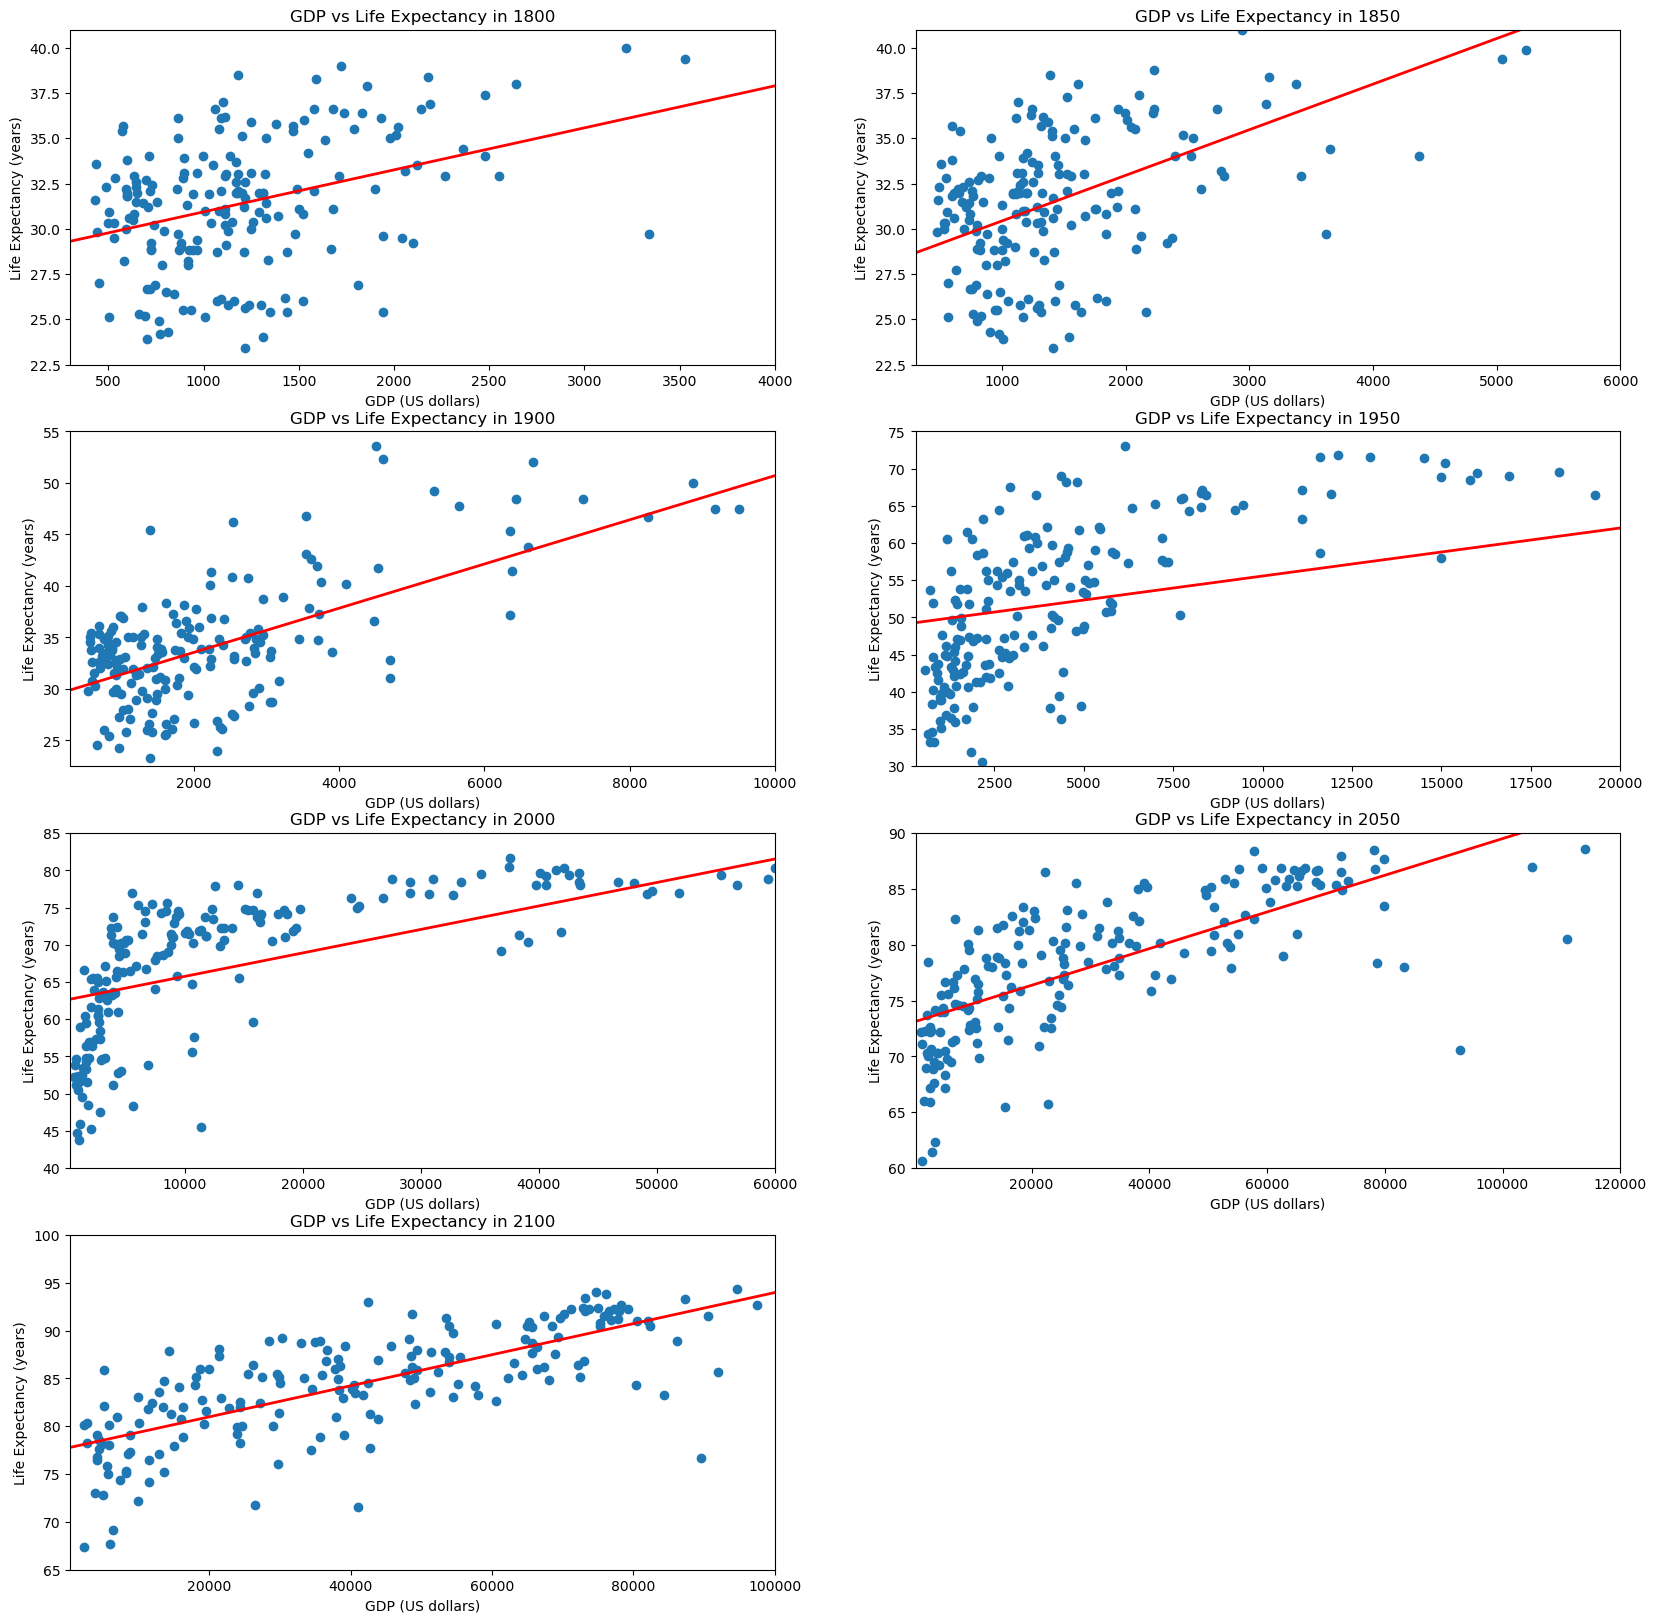

In [54]:
plt.figure(figsize=(20,20))


plt.subplot(4,2,1)
plt.scatter(plot_dict['1800'][0],plot_dict['1800'][1])
x_val=range(0,4100,100)
plt.plot(x_val,regr_dict['1800'][1]*x_val+regr_dict['1800'][0],'r',linewidth=2)
plt.axis([300,4000,22.5,41])
plt.title('GDP vs Life Expectancy in 1800')
plt.xlabel('GDP (US dollars)')
plt.ylabel('Life Expectancy (years)')

plt.subplot(4,2,2)
plt.scatter(plot_dict['1850'][0],plot_dict['1850'][1])
x_val=range(0,6100,100)
plt.plot(x_val,regr_dict['1850'][1]*x_val+regr_dict['1850'][0],'r',linewidth=2)
plt.axis([300,6000,22.5,41])
plt.title('GDP vs Life Expectancy in 1850')
plt.xlabel('GDP (US dollars)')
plt.ylabel('Life Expectancy (years)')

plt.subplot(4,2,3)
plt.scatter(plot_dict['1900'][0],plot_dict['1900'][1])
x_val=range(0,10100,100)
plt.plot(x_val,regr_dict['1900'][1]*x_val+regr_dict['1900'][0],'r',linewidth=2)
plt.axis([300,10000,22.5,55])
plt.title('GDP vs Life Expectancy in 1900')
plt.xlabel('GDP (US dollars)')
plt.ylabel('Life Expectancy (years)')

plt.subplot(4,2,4)
plt.scatter(plot_dict['1950'][0],plot_dict['1950'][1])
x_val=range(0,20100,100)
plt.plot(x_val,regr_dict['1950'][1]*x_val+regr_dict['1950'][0],'r',linewidth=2)
plt.axis([300,20000,30,75])
plt.title('GDP vs Life Expectancy in 1950')
plt.xlabel('GDP (US dollars)')
plt.ylabel('Life Expectancy (years)')

plt.subplot(4,2,5)
plt.scatter(plot_dict['2000'][0],plot_dict['2000'][1])
x_val=range(0,60100,100)
plt.plot(x_val,regr_dict['2000'][1]*x_val+regr_dict['2000'][0],'r',linewidth=2)
plt.axis([300,60000,40,85])
plt.title('GDP vs Life Expectancy in 2000')
plt.xlabel('GDP (US dollars)')
plt.ylabel('Life Expectancy (years)')

plt.subplot(4,2,6)
plt.scatter(plot_dict['2050'][0],plot_dict['2050'][1])
x_val=range(0,120100,100)
plt.plot(x_val,regr_dict['2050'][1]*x_val+regr_dict['2050'][0],'r',linewidth=2)
plt.axis([300,120000,60,90])
plt.title('GDP vs Life Expectancy in 2050')
plt.xlabel('GDP (US dollars)')
plt.ylabel('Life Expectancy (years)')

plt.subplot(4,2,7)
plt.scatter(plot_dict['2100'][0],plot_dict['2100'][1])
x_val=range(0,120100,100)
plt.plot(x_val,regr_dict['2100'][1]*x_val+regr_dict['2100'][0],'r',linewidth=2)
plt.axis([300,100000,65,100])
plt.title('GDP vs Life Expectancy in 2100')
plt.xlabel('GDP (US dollars)')
plt.ylabel('Life Expectancy (years)')


plt.show()

<p>Let us see if a logarithmic transformation can provide a better model to describe the relation between GDP and life expectancy. As en example, we will look at the data for 1950.</p>

In [55]:
model1950=sm.OLS.from_formula('le1950 ~ np.log(gdp1950)',life_gdp)
results1950=model1950.fit()
x_transform=np.log(life_gdp['gdp1950'])
residuals1950=life_gdp['le1950']-(results1950.params[1]*x_transform+results1950.params[0])

x_regr=range(10,70000,10)
x_log=np.log(x_regr)
y_regr=results1950.params[1]*x_log+results1950.params[0]

Text(0, 0.5, 'Life Expectancy (years)')

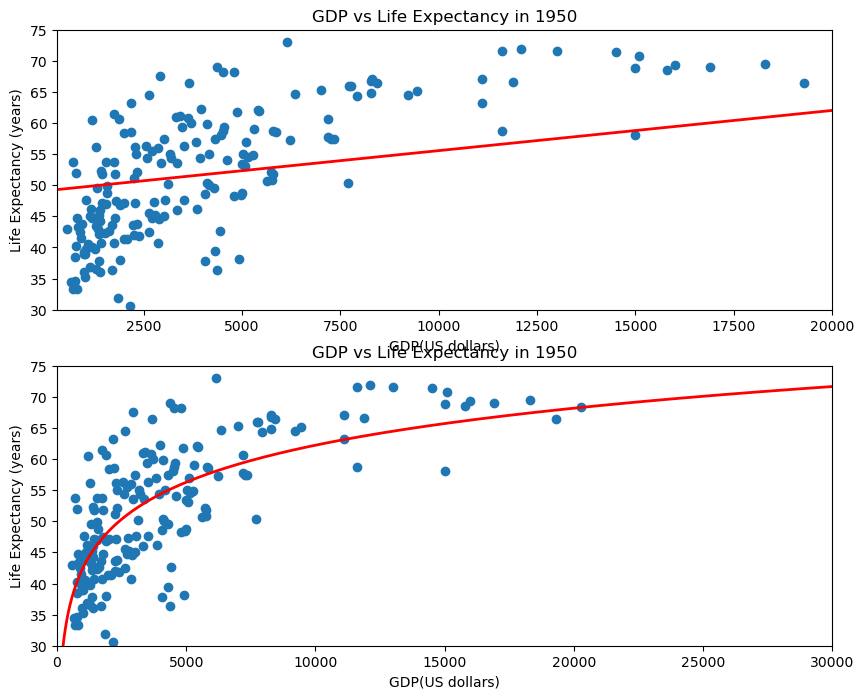

In [56]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.scatter(plot_dict['1950'][0],plot_dict['1950'][1])
x_val=range(0,20100,100)
plt.plot(x_val,regr_dict['1950'][1]*x_val+regr_dict['1950'][0],'r',linewidth=2)
plt.axis([300,20000,30,75])
plt.title('GDP vs Life Expectancy in 1950')
plt.xlabel('GDP(US dollars)')
plt.ylabel('Life Expectancy (years)')


plt.subplot(2,1,2)
plt.scatter(plot_dict['1950'][0],plot_dict['1950'][1])
plt.plot(x_regr,y_regr,'r',linewidth=2)
plt.axis([0,30000,30,75])
plt.title('GDP vs Life Expectancy in 1950')
plt.xlabel('GDP(US dollars)')
plt.ylabel('Life Expectancy (years)')


<p>The second curve looks much better. Let's look at the summaries of the two models for a more detailed comparison.</p>

<p>The summary for the linear model is below. Low R-squared values, high condition number, the F-statistic indicate a pretty low model significance.</p>

In [57]:
st1='le'+'1950'
st2='gdp'+'1950'
expr=st1+' ~ '+st2
model=sm.OLS.from_formula(expr, life_gdp)
results=model.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 le1950   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     37.50
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           5.39e-09
Time:                        08:46:22   Log-Likelihood:                -680.37
No. Observations:                 186   AIC:                             1365.
Df Residuals:                     184   BIC:                             1371.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     49.1091      0.849     57.841      0.000      47.434      50.784
gdp1950        0.0006      0.000      6.124      0.000       0.000       0.001
==============================================================================
Omnibus:                       22.566   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.574
Skew:                          -0.637   Prob(JB):                     4.20e-09
Kurtosis:                       4.832   Cond. No.                     9.88e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<p>On the contrary, the logarithmic model shows much better results. The logarithmic model's R-squared value is 0.509, which suggests that approximately 50.9% of the variability in life expectancy is explained by the model. The logarithmic model possesses a substantially higher F-statistic (191.1) with a very low probability value (Prob (F-statistic): 2.87e-30), suggesting the model's explanatory variables are statistically significant predictors of life expectancy. The condition number is significantly lower for the logarithmic model (77.4) than for the linear model (9.88e+03), which suggests that the logarithmic model is less sensitive to multicollinearity and more stable numerically.</p>

In [58]:
display(results1950.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 le1950   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     191.1
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           2.87e-30
Time:                        08:46:22   Log-Likelihood:                -631.39
No. Observations:                 186   AIC:                             1267.
Df Residuals:                     184   BIC:                             1273.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -16.8099      5.015     -3.352      0.001     -26.705      -6.915
np.log(gdp1950)     8.5811      0.621     13.823      0.000       7.356       9.806
==============================================================================
Omnibus:                        7.651   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                8.628
Skew:                          -0.337   Prob(JB):                       0.0134
Kurtosis:                       3.811   Cond. No.                         77.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<p>Let's plot the residuals histogram and scatterplot to check normality and homoscedasticity for the logarithmic model.</p>

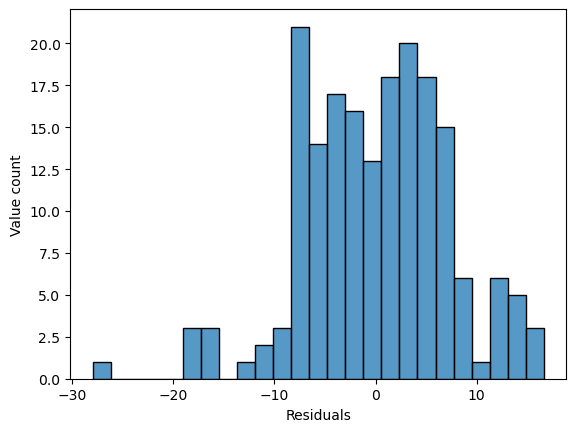

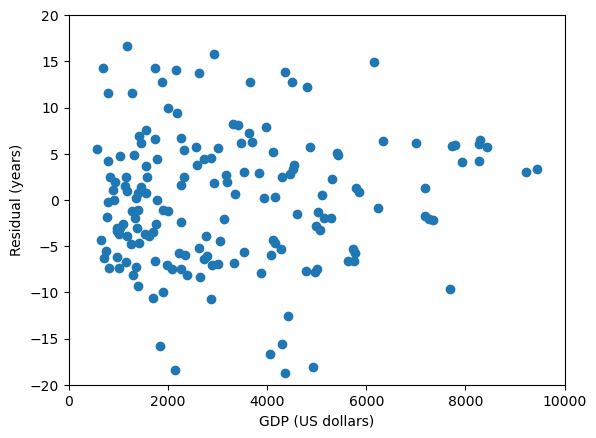

<Figure size 640x480 with 0 Axes>

In [63]:
sns.histplot(residuals1950,bins=25)
plt.xlabel("Residuals")
plt.ylabel("Value count")
plt.show()
plt.clf()

plt.scatter(life_gdp['gdp1950'],residuals1950)
plt.axis([0,10000,-20,20])
plt.xlabel("GDP (US dollars)")
plt.ylabel("Residual (years)")
plt.show()
plt.clf()

<p>The logarithmic model for the data in 2000 works even better, with R-squared equal to 0.65, and a high value F-statistic with a low value of Prob (F-statstic).</p>

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 le2000   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     343.4
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           6.13e-44
Time:                        08:46:22   Log-Likelihood:                -584.80
No. Observations:                 186   AIC:                             1174.
Df Residuals:                     184   BIC:                             1180.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          10.6359      3.089      3.444      0.001       4.542      16.729
np.log(gdp2000)     6.3356      0.342     18.531      0.000       5.661       7.010
==============================================================================
Omnibus:                       37.172   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.348
Skew:                          -1.049   Prob(JB):                     7.86e-14
Kurtosis:                       4.840   Cond. No.                         68.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Life Expectancy (years)')

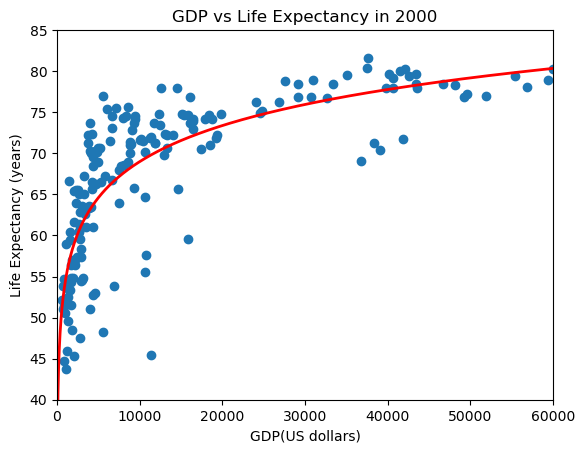

In [60]:
model2000=sm.OLS.from_formula('le2000 ~ np.log(gdp2000)',life_gdp)
results2000=model2000.fit()
x_transform=np.log(life_gdp['gdp2000'])
residuals2000=life_gdp['le2000']-(results2000.params[1]*x_transform+results2000.params[0])
display(results2000.summary())

x_regr=range(10,70000,10)
x_log=np.log(x_regr)
y_regr=results2000.params[1]*x_log+results2000.params[0]

plt.scatter(plot_dict['2000'][0],plot_dict['2000'][1])
plt.plot(x_regr,y_regr,'r',linewidth=2)
plt.axis([0,60000,40,85])
plt.title('GDP vs Life Expectancy in 2000')
plt.xlabel('GDP(US dollars)')
plt.ylabel('Life Expectancy (years)')

<p>Same is true for the 2050 & 2100 data! </p>

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 le2050   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     294.8
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           4.56e-40
Time:                        08:46:22   Log-Likelihood:                -511.85
No. Observations:                 186   AIC:                             1028.
Df Residuals:                     184   BIC:                             1034.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          36.3760      2.445     14.881      0.000      31.553      41.199
np.log(gdp2050)     4.2474      0.247     17.171      0.000       3.759       4.735
==============================================================================
Omnibus:                       22.282   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.634
Skew:                          -0.766   Prob(JB):                     6.06e-07
Kurtosis:                       4.161   Cond. No.                         87.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Life Expectancy (years)')

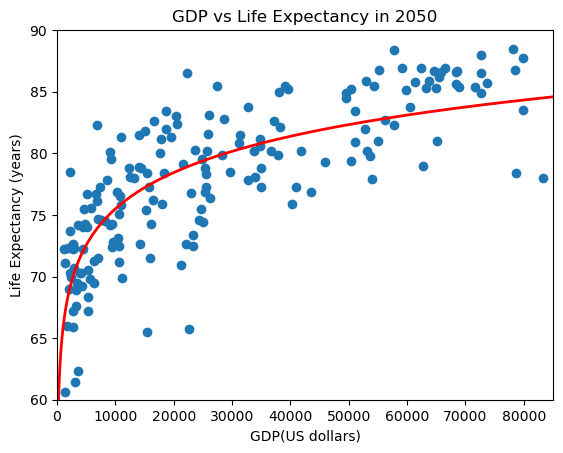

In [61]:
model2050=sm.OLS.from_formula('le2050 ~ np.log(gdp2050)',life_gdp)
results2050=model2050.fit()
x_transform=np.log(life_gdp['gdp2050'])
residuals2050=life_gdp['le2050']-(results2050.params[1]*x_transform+results2050.params[0])
display(results2050.summary())

x_regr=range(10,90000,10)
x_log=np.log(x_regr)
y_regr=results2050.params[1]*x_log+results2050.params[0]

plt.scatter(plot_dict['2050'][0],plot_dict['2050'][1])
plt.plot(x_regr,y_regr,'r',linewidth=2)
plt.axis([0,85000,60,90])
plt.title('GDP vs Life Expectancy in 2050')
plt.xlabel('GDP(US dollars)')
plt.ylabel('Life Expectancy (years)')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 le2100   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     221.4
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           2.16e-33
Time:                        08:46:22   Log-Likelihood:                -515.02
No. Observations:                 186   AIC:                             1034.
Df Residuals:                     184   BIC:                             1040.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          37.5304      3.165     11.859      0.000      31.287      43.774
np.log(gdp2100)     4.5499      0.306     14.880      0.000       3.947       5.153
==============================================================================
Omnibus:                       19.543   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.435
Skew:                          -0.727   Prob(JB):                     8.15e-06
Kurtosis:                       3.954   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Life Expectancy (years)')

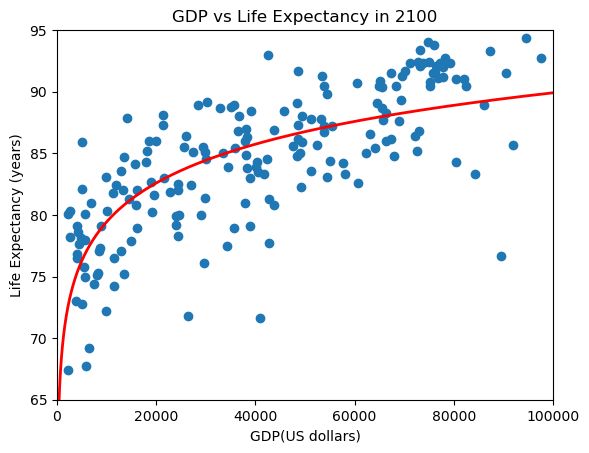

In [62]:
model2100=sm.OLS.from_formula('le2100 ~ np.log(gdp2100)',life_gdp)
results2100=model2100.fit()
x_transform=np.log(life_gdp['gdp2100'])
residuals2100=life_gdp['le2100']-(results2100.params[1]*x_transform+results2100.params[0])
display(results2100.summary())

x_regr=range(10,100000,10)
x_log=np.log(x_regr)
y_regr=results2100.params[1]*x_log+results2100.params[0]

plt.scatter(plot_dict['2100'][0],plot_dict['2100'][1])
plt.plot(x_regr,y_regr,'r',linewidth=2)
plt.axis([0,100000,65,95])
plt.title('GDP vs Life Expectancy in 2100')
plt.xlabel('GDP(US dollars)')
plt.ylabel('Life Expectancy (years)')

<h2>Conclusion</h2>

<ul>
<li>In this notebook we have worked with two datasets, containing world countries' GDPs and life expectancies over the years. After cleaning and preparing the data we ended up with a table allowing to compare GDPs and life expectancies in years 1800,1850,1900,1950,2000 and 2050,2100 (expected).</li>
<li>Plotting the scatterplots for each of the years under consideration, we noticed that there is a positive relation between the two variables.</li>
<li>The first idea coming into mind -- linear regression models -- turned out to be not the best choice, especially for years 1950,2000,2050.</li>
<li>We could fit the data into more suitable regression models -- logarithmic ones. They turned out that the logarithmic model provides a much more accurate and reliable representation of the relationship between GDP and life expectancy. </li>
</ul>